# Amazon Beauty & Personal Care Reviews – Sentiment Classification

**Course:** CSE 158

**Dataset:** Amazon Reviews 2023 – *Beauty and Personal Care*  

**Task:** Predict whether a product review is **positive (rating ≥ 4)** or **negative (rating ≤ 3)** based on its text.

In this notebook, we will:

1. Describe the predictive task and dataset  
2. Perform exploratory data analysis (EDA)  
3. Build baselines (majority-class)  
4. Train a TF–IDF + Logistic Regression classifier  
5. Evaluate performance and interpret the model  
6. Discuss limitations and future work

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

import seaborn as sns
import joblib


In [ ]:
df = pd.read_csv("df_ready.csv")
print(df.head())
print("\nShape:", df.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'df_ready.csv'

## 1. Dataset Summary

We use the **Beauty and Personal Care** subset of the Amazon Reviews 2023 dataset.  
From the full 23.9M reviews, we sampled approximately 1% and cleaned it to obtain `df_ready.csv`.

Each row contains:
- `text`: the review text
- `title`: review title
- `rating`: original star rating (1–5)
- `user_id`: reviewer ID
- `asin`: product ID
- `label`: binary sentiment label  
  - `1` = positive (rating ≥ 4)  
  - `0` = negative (rating ≤ 3)

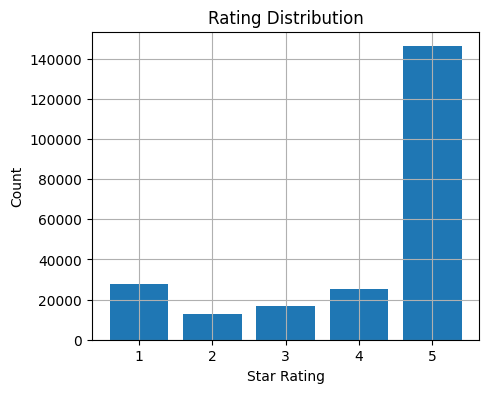

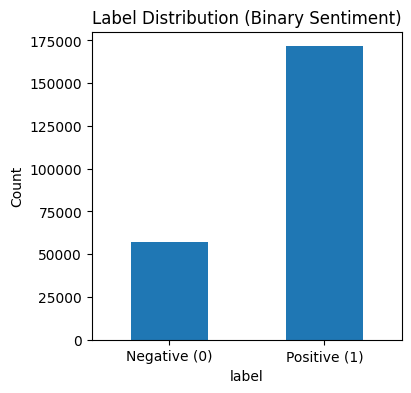

label
0    0.249706
1    0.750294
Name: count, dtype: float64

In [ ]:
if "rating" in df.columns:
    plt.figure(figsize=(5,4))
    df["rating"].hist(bins=[1,2,3,4,5,6], align="left", rwidth=0.8)
    plt.xlabel("Star Rating")
    plt.ylabel("Count")
    plt.title("Rating Distribution")
    plt.show()

plt.figure(figsize=(4,4))
label_counts = df["label"].value_counts().sort_index()
label_counts.plot(kind="bar")
plt.xticks([0,1], ["Negative (0)", "Positive (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Label Distribution (Binary Sentiment)")
plt.show()

label_counts / label_counts.sum()

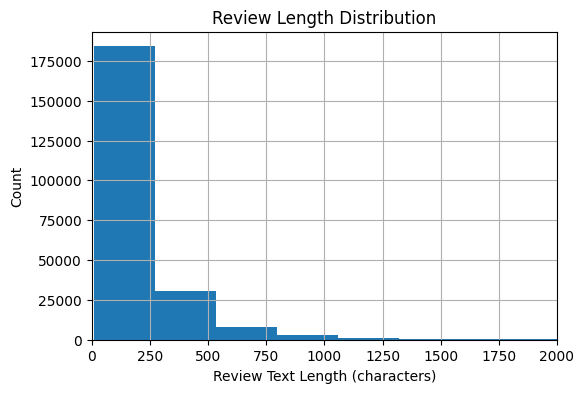

count    228581.000000
mean        186.039093
std         246.570572
min          11.000000
25%          52.000000
50%         114.000000
75%         227.000000
max       13098.000000
Name: text_len, dtype: float64

In [ ]:
df["text_len"] = df["text"].str.len()

plt.figure(figsize=(6,4))
df["text_len"].hist(bins=50)
plt.xlabel("Review Text Length (characters)")
plt.ylabel("Count")
plt.title("Review Length Distribution")
plt.xlim(0, 2000)
plt.show()

df["text_len"].describe()


## 2. Sample Reviews
Below are a few example reviews from the dataset.


In [ ]:
pd.set_option("display.max_colwidth", 200)
df[["title","rating", "label", "text"]].sample(5, random_state=100)

,title,rating,label,text
36251,it us very expensive but people do not stop complimenting the light fragrance. it lasts for hours.,5.0,1,the value is great but i had to think long and hard about buying it because of budget restraints.
53484,five stars,5.0,1,love the scrub.
157429,four stars,4.0,1,does the best job out of any i've purchased for my husband. would recommend.
25495,five stars,5.0,1,works great have bought multiple now.
92681,great color,5.0,1,i’ve been using this color for years. my hair is light brown with blonde highlights. it’s the only pencil color that’s worked for me.


In [ ]:
# Simple token frequency (just for EDA; TF-IDF will be more rigorous later)
def tokenize(s):
    return s.split()

sample_texts = df["text"].sample(20000, random_state=42)
counter = Counter()

for t in sample_texts:
    counter.update(tokenize(t))

most_common = counter.most_common(20)
most_common


[('the', 26646),
 ('i', 26074),
 ('and', 21667),
 ('it', 18476),
 ('a', 16386),
 ('to', 15749),
 ('my', 12543),
 ('this', 12506),
 ('is', 10535),
 ('for', 9488),
 ('of', 7800),
 ('but', 6117),
 ('in', 5946),
 ('not', 5772),
 ('on', 5530),
 ('have', 5367),
 ('with', 5275),
 ('that', 5155),
 ('was', 5133),
 ('so', 4848)]

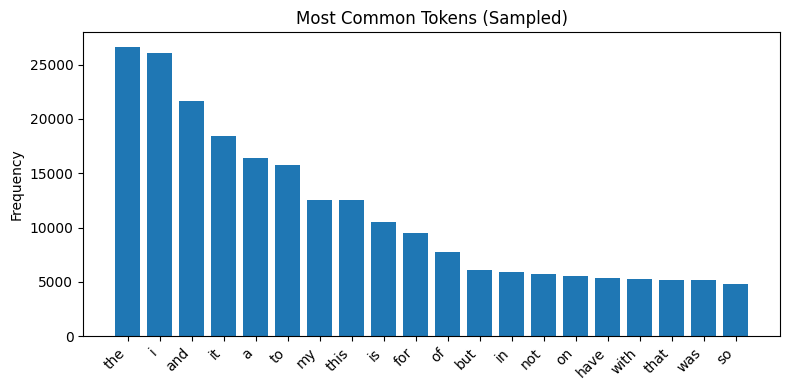

In [ ]:
words, counts = zip(*most_common)
plt.figure(figsize=(8,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")
plt.title("Most Common Tokens (Sampled)")
plt.tight_layout()
plt.show()


## 3. Predictive Task

**Goal:**  
Given the text of a review, predict whether the underlying rating is **positive (≥4 stars)** or **negative (≤3 stars)**.

After looking at how binary classification turned out, we will also run experiments on rating prediction (1 through 5) since that is the format for amazon.

**Input features:**
- `text` (main feature, free-form review text)
- Optionally, `title` can be concatenated to `text` (not strictly necessary)

**Target:**
*Binary classification*
- `label ∈ {0,1}`  
  - `0`: negative review  
  - `1`: positive review

*Rating classification*
- `label ∈ {1, 2, 3, 4, 5}`


We evaluate models using:

- Accuracy  
- Precision, Recall, F1  
- ROC–AUC  
- Confusion matrix


# Binary Classification

In [9]:
X = df["text"].astype(str).values
y = df["label"].values

# 80 / 10 / 10 split with stratification
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42, stratify=y_train_full
)

print("Train size:", len(X_train))
print("Valid size:", len(X_valid))
print("Test size: ", len(X_test))


Train size: 182866
Valid size: 22856
Test size:  22859


In [10]:
def print_basic_stats(y_true, y_pred, y_proba=None, split_name=""):
    print(f"\n=== {split_name} performance ===")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")

    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"AUC:       {auc:.4f}")
        except ValueError:
            print("AUC could not be computed (only one class present).")

    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))

# Majority baseline
majority_class = int(np.bincount(y_train).argmax())
print("Majority class (training):", majority_class)

y_valid_maj = np.full_like(y_valid, majority_class)
print_basic_stats(y_valid, y_valid_maj, split_name="VALID (Majority Baseline)")


Majority class (training): 1

=== VALID (Majority Baseline) performance ===
Accuracy:  0.7503
Precision: 0.7503
Recall:    1.0000
F1:        0.8573

Confusion matrix:
[[    0  5707]
 [    0 17149]]

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5707
           1       0.75      1.00      0.86     17149

    accuracy                           0.75     22856
   macro avg       0.38      0.50      0.43     22856
weighted avg       0.56      0.75      0.64     22856



In [11]:
RETRAIN = False  # set to True if you want to retrain inside the notebook

VECTORIZER_FILE = "tfidf_vectorizer.pkl"
MODEL_FILE = "logreg_model.pkl"

if RETRAIN:
    print("Fitting TF-IDF vectorizer...")
    vectorizer = TfidfVectorizer(
        max_features=100_000,
        ngram_range=(1, 2),
        stop_words="english"
    )
    X_train_tf = vectorizer.fit_transform(X_train)
    X_valid_tf = vectorizer.transform(X_valid)
    X_test_tf  = vectorizer.transform(X_test)

    print("TF-IDF shapes:")
    print("  Train:", X_train_tf.shape)
    print("  Valid:", X_valid_tf.shape)
    print("  Test: ", X_test_tf.shape)

    print("\nTraining Logistic Regression...")
    clf = LogisticRegression(max_iter=200, n_jobs=-1, verbose=1)
    clf.fit(X_train_tf, y_train)

    # Save for reuse
    joblib.dump(vectorizer, VECTORIZER_FILE)
    joblib.dump(clf, MODEL_FILE)
else:
    print("Loading existing TF-IDF vectorizer and Logistic Regression model...")
    vectorizer = joblib.load(VECTORIZER_FILE)
    clf = joblib.load(MODEL_FILE)

    X_train_tf = vectorizer.transform(X_train)
    X_valid_tf = vectorizer.transform(X_valid)
    X_test_tf  = vectorizer.transform(X_test)

print("Done preparing features and model.")


Loading existing TF-IDF vectorizer and Logistic Regression model...
Done preparing features and model.


In [12]:
from sklearn.svm import LinearSVC

print("\nTraining Linear SVM model...")

svm_clf = LinearSVC()
svm_clf.fit(X_train_tf, y_train)

print("Evaluating Linear SVM model...")

# VALIDATION
y_valid_pred_svm = svm_clf.predict(X_valid_tf)
print_basic_stats(
    y_valid, 
    y_valid_pred_svm, 
    split_name="VALID (Linear SVM)"
)

# TEST
y_test_pred_svm = svm_clf.predict(X_test_tf)
print_basic_stats(
    y_test, 
    y_test_pred_svm, 
    split_name="TEST (Linear SVM)"
)



Training Linear SVM model...
Evaluating Linear SVM model...

=== VALID (Linear SVM) performance ===
Accuracy:  0.8924
Precision: 0.9177
Recall:    0.9409
F1:        0.9292

Confusion matrix:
[[ 4260  1447]
 [ 1013 16136]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      5707
           1       0.92      0.94      0.93     17149

    accuracy                           0.89     22856
   macro avg       0.86      0.84      0.85     22856
weighted avg       0.89      0.89      0.89     22856


=== TEST (Linear SVM) performance ===
Accuracy:  0.8885
Precision: 0.9122
Recall:    0.9421
F1:        0.9269

Confusion matrix:
[[ 4153  1555]
 [  993 16158]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      5708
           1       0.91      0.94      0.93     17151

    accuracy                           0.89     22859
   macro avg       0.86

In [13]:
# Validation
y_valid_pred = clf.predict(X_valid_tf)
y_valid_proba = clf.predict_proba(X_valid_tf)[:, 1]
print_basic_stats(y_valid, y_valid_pred, y_valid_proba, split_name="VALID (LogReg)")

# Test
y_test_pred = clf.predict(X_test_tf)
y_test_proba = clf.predict_proba(X_test_tf)[:, 1]
print_basic_stats(y_test, y_test_pred, y_test_proba, split_name="TEST (LogReg)")



=== VALID (LogReg) performance ===
Accuracy:  0.8953
Precision: 0.9084
Recall:    0.9570
F1:        0.9321
AUC:       0.9408

Confusion matrix:
[[ 4052  1655]
 [  737 16412]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      5707
           1       0.91      0.96      0.93     17149

    accuracy                           0.90     22856
   macro avg       0.88      0.83      0.85     22856
weighted avg       0.89      0.90      0.89     22856


=== TEST (LogReg) performance ===
Accuracy:  0.8930
Precision: 0.9056
Recall:    0.9571
F1:        0.9306
AUC:       0.9394

Confusion matrix:
[[ 3997  1711]
 [  736 16415]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.77      5708
           1       0.91      0.96      0.93     17151

    accuracy                           0.89     22859
   macro avg       0.88      0.83      0.85     22859
we

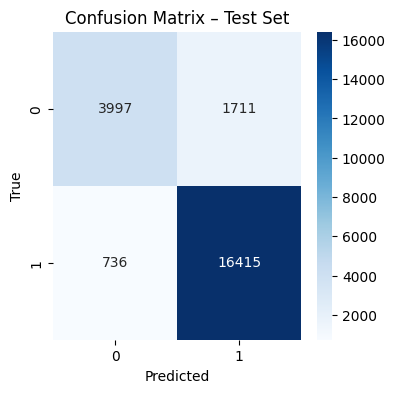

In [14]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Test Set")
plt.show()


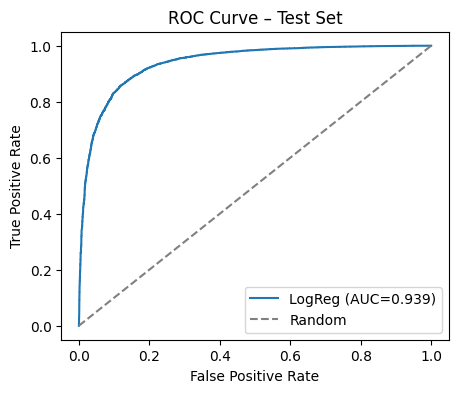

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label="LogReg (AUC={:.3f})".format(roc_auc_score(y_test, y_test_proba)))
plt.plot([0,1], [0,1], "--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set")
plt.legend()
plt.show()


### Multiclass Performance Experiment 

Using the best Logistic Regression model, we can establish a baseline for multiclass classification. Here we are classifying each review from 1 to 5 and only looking at the accuracy to establish a baseline.

In [ ]:
# Multiclass classification: predict rating 1-5
# Reuse the same train/val/test split but with raw rating as target instead of binary classification

y_multi = df["rating"].astype(int).values #creating labels from ratings 

X_train_full_m, X_test_m, y_train_full_m, y_test_m = train_test_split(
    X, y_multi, test_size=0.1, random_state=42, stratify=y_multi
)

X_train_m, X_valid_m, y_train_m, y_valid_m = train_test_split(
    X_train_full_m, y_train_full_m, test_size=0.1111, random_state=42, stratify=y_train_full_m
)

# Transform using existing vectorizer for tf-idf
X_train_tf_m = vectorizer.transform(X_train_m)
X_valid_tf_m = vectorizer.transform(X_valid_m)
X_test_tf_m = vectorizer.transform(X_test_m)

clf_multi = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    multi_class="multinomial",
    n_jobs=-1
)
clf_multi.fit(X_train_tf_m, y_train_m)

y_valid_pred_m = clf_multi.predict(X_valid_tf_m)
y_test_pred_m = clf_multi.predict(X_test_tf_m)

print(f"\nMulticlass Validation")
print(f"Accuracy: {accuracy_score(y_valid_m, y_valid_pred_m):.4f}")
print(f"\nMulticlass Test")
print(f"Accuracy: {accuracy_score(y_test_m, y_test_pred_m):.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_m, y_test_pred_m))

print("\nClassification Report (Test):")
print(classification_report(y_test_m, y_test_pred_m, zero_division=0))

## 4. Baseline vs Model Performance

We compare the **majority-class baseline** against the **TF–IDF + Logistic Regression** model:

- The baseline predicts the majority label (positive) for all examples.
- The TF–IDF + LR model uses text features and learns a linear decision boundary.

From our experiments:

- Baseline accuracy ≈ 0.75 (heavily biased toward the positive class)
- LogReg accuracy ≈ 0.89
- LogReg AUC ≈ 0.94

This shows a large improvement when using text-based features and a learned classifier.


In [16]:
put results here

SyntaxError: invalid syntax (1519981530.py, line 1)

In [17]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]

top_pos_words = pd.DataFrame({
    "word": feature_names[top_pos_idx],
    "coef": coefs[top_pos_idx]
}).sort_values("coef", ascending=False)

top_neg_words = pd.DataFrame({
    "word": feature_names[top_neg_idx],
    "coef": coefs[top_neg_idx]
}).sort_values("coef", ascending=True)

print("Top positive words:")
display(top_pos_words)

print("\nTop negative words:")
display(top_neg_words)


Top positive words:


,word,coef
19,love,16.882162
18,perfect,11.115012
17,great,10.212931
16,amazing,9.709341
15,best,8.260222
14,awesome,7.938312
13,loves,7.780892
12,excellent,7.746340
11,glad,7.385425
10,compliments,6.683499



Top negative words:


,word,coef
0,disappointed,-8.808137
1,worst,-8.459611
2,return,-7.627454
3,disappointing,-7.622148
4,horrible,-7.293662
5,returning,-7.130944
6,terrible,-6.977661
7,useless,-6.817698
8,broke,-6.663719
9,awful,-6.553039


## 5. Limitations and Future Work

**Limitations:**
- The dataset is skewed toward positive reviews (~75% positive), so even a naive baseline performs moderately well.
- TF–IDF ignores word order and long-range dependencies in text.
- We do not use additional metadata (price, brand, images), which could help disambiguate borderline cases.
- Some reviews may be sarcastic, ambiguous, or off-topic, which is challenging for simple text models.

**Potential improvements:**
- Use a transformer-based model (e.g., DistilBERT) fine-tuned on a subset of Beauty reviews.
- Incorporate review metadata (verified purchase, helpful votes) as extra features.
- Explore calibration techniques to better interpret predicted probabilities.
- Train per-subcategory models (e.g., skincare vs haircare) to capture more specific patterns.


## 6. Conclusion

We framed sentiment analysis for **Amazon Beauty & Personal Care** reviews as a binary classification problem.

- **Baseline:** A majority-class baseline achieves ~75% accuracy but fails to identify negative reviews.
- **Model:** A TF–IDF + Logistic Regression classifier substantially improves performance:
  - ~89% accuracy on the test set
  - ROC–AUC around 0.94
  - Much better balance between precision and recall for both classes

Despite its simplicity, this classical text model performs strongly on large-scale review data and is computationally efficient and interpretable. It also aligns well with the models and techniques covered in CSE 158.
